<a href="https://colab.research.google.com/github/jeekyung/ESAA/blob/main/%ED%8C%8C%EC%9D%B4%EC%8D%AC_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_%EC%99%84%EB%B2%BD%EA%B0%80%EC%9D%B4%EB%93%9C_pg_227~251%2C278~289.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **06 XGBoost(eXtra Gradient Boost)**

---

##**XGBoost 개요**

: 트리 기반의 앙상블 학습에서 가장 각광받고 있는 알고리즘 중 하나.

[장점]
* 뛰어난 예측 성능
* GBM 대비 빠른 수행 시간
* 과적합 규제(Regularization)
* Tree pruning(나무 가지치기)
* 자체 내장된 교차 검증
* 결손값 자체 처리

In [33]:
import xgboost as xgb
from xgboost import XGBClassifier

###**파이썬 래퍼 XGBoost 하이퍼 파라미터**

하이퍼 파라미터가 유형별로 나뉨
* **1)일반 파라미터**: 일반적으로 실행 시 스레드의 개수나 silent 모드 등의 선택을 위한 파라미터로서 디폴트 파라미터 값을 바꾸는 경우는 많이 없음
* **2)부스터 파라미터**: 트리 최적화, 부스팅, regularization 등과 관련 파라미터 등을 지칭
* **3)학습 태스크 파라미터**: 학습 수행 시의 객체 함수. 평가를 위한 지표 등을 설정하는 파라미터

(대부분의 하이퍼 파라미터는 Booster 파라미터에 속함

**1)주요 일반 파라미터**
* **booster**:gbtree(tree based model) 또는 gblinear(linear model)) 선택. 디폴트는 gbtree
* **silent**: 디폴트는 0이며, 출력 메세지를 나타내고 싶지 않을 경우 1로 설정
* **nthread**: CPU의 실행 스레드 개수를 조정하며, 디폴트는 CPU의 전체 스레드를 다 사용하는 것. 멀티 코어/스레드 CPU 시스템에서 전체 CPU를 사용하지 않고 일부 CPU만 사용해 ML 애플리케이션을 구동하는 경우에 변경

**2)주요 부스터 파라미터**
* **eta[default=0.3, alias: learning_rate]**: GBM의 학습률(learning rate)과 같은 파라미터. 0과 1 사이의 값을 지정하며 부스팅 스텝을 반복적으로 수행할 때 업데이트되는 학습률 값, 파이썬 래퍼 기반의 xgboost를 이용할 경우 디폴트는 0.3. 사이킷런 래퍼 클래스를 이용할 경우 eta는 learning_rate 파라미터로 대체되며, 디폴트는 0.1. 보통은 0.01~0.2 사이의 값 선호.
* **num_boost_rounds**: GBM의 n_estimators와 같은 파라미터
* **min_child_weight[default=1]**: 트리에서 추가적으로 가지를 나눌지를 결정하기 위해 필요한 데이터들의 weight 총합. min_child_weight이 클수록 분할 자제. 과적합을 조절하기 위해 사용됨.
* **gamma[default=0,alias: min_split_loss]**: 트리에서 추가적으로 가지를 나눌지를 결정할 최소 손실 감소 값. 해당 값보다 큰 손실(loss)이 감소된 경우에 리프 노드를 분리. 값이 클수록 과적합 감소 효과가 있음
* **max_depth[default=6]**: 트리 기반 알고리즘의 max_depth와 같음. 0을 지정하면 깊이에 제한이 없음. max_depth가 높으면 특정 피처 조건에 특화되어 룰 조건이 만들어지므로 과적합 가능성이 높아지며 보통은 3~10 사이의 값을 적용
* **sub_sample[default=1]**: GBM의 subsample과 동일. 트리가 커져서 과적합되는 것을 제어하기 위해 데이터를 샘플링하는 비율을 지정. sub_sample=0.5로 지정하면 전체 데이터의 절반을 트리를 생성하는 데 사용. 0에서 1 사이의 값이 가능하나 일반적으로 0.5~1 사이의 값을 사용.
* **colsample_bytree[default=1]**: GBM의 max_features와 유사함. 트리 생성에 필요한 피처(칼럼)를 임의로 샘플링 하는 데 사용됨. 매우 많은 피처가 있는 경우 과적합을 조정하는 데 적용함.
* **lambda[default=1, alias: reg_lambda]**: L2 Regularization 적용 값. 피처 개수가 많을 경우 적용을 검토하며 값이 클수록 과적합 감소 효과가 있음
* alpha[default=0, alias:reg_alpha] **굵은 텍스트**: L1 Regularization 적용 값. 피처 개수가 많을 경우 적용을 검토하며 값이 클수록 과적합 감소 효과 있음
* **scale_pos_weight[default=1]**: 특정 값으로 치우친 비대칭한 클래스로 구성된 데이터 세트의 균형을 유지하기 위한 파라미터

**3)학습 태스크 파라미터**
* **objective:** 최솟값을 가져야할 손실 함수를 정의함. XGBoost는 많은 유형의 손실함수 사용 가능. 주로 사용되는 손실함수는 이진 분류인지 다중 분류인지에 따라 달라짐
* **binary:logistic**: 이진 분류일 때 적용
* **multi:softmax**: 다중 분류일 때 적용. 손실함수가 multi:softmax일 경우에는 레이블 클래스의 개수인 num_class 파라미터를 지정해야함
* **multi:softprob**: multi:softmax와 유사하나 개별 레이블 클래스의 해당되는 예측 확률을 반환함
* **eval_metric**: 검증에 사용되는 함수를 정의. 기본값은 회귀인 경우는 rmse, 분류일 경우에는 error. 다음은 eval_metric의 값 유형

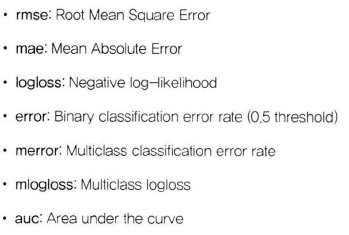

과적합 문제가 심각하다면
* eta 값을 낮춤(0.01~0.1). eta 값을 낮출 경우 num_round(또는 n_estimators)는 반대로 높여줘야함
* max_depth 값을 낮춤
* min_child_weight 값을 높임
* gamma 값을 높임
* subsample과 colsample_bytree를 조정(트리가 과하게 복잡해지는 것 방지)

---

**파이썬 래퍼 XGBoost 적용 - 위스콘신 유방암 예측**

XGBoost의 파이썬 패키지인 xgboost는 자체적으로 교차 검증, 성능 평가, 피처 중요도 등의 시각화(plotting) 기능을 가지고 있음

또한 조기 중단 기능이 있어서 num_rounds로 지정한 부스팅 반복 횟수에 도달하지 않더라도 더 이상 예측 오류가 개선되지 않으면 반복을 끝까지 수행하지 않고 중지해 수행 시간을 개선하는 기능도 가지고 있음

<u>위스콘신 유방암 데이터 세트</u>는 종양의 크기, 모양 등의 다양한 속성값을 기반으로 악성 종양(malignant)인지 양성 종양(benign)인지를 분류한 데이터 세트.

양성 종양이 비교적 성장 속도가 느리고 전이되지 않는 것에 반해, 악성 종양은 주위 조직에 침입하면서 빠르게 성장하고 신체 각 부위에 확산되거나 전이되어 생명을 위혐

In [34]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset =load_breast_cancer()
X_features = dataset.data
y_label = dataset.target
cancer_df = pd.DataFrame(data=X_features, columns=dataset.feature_names)
cancer_df['target'] = y_label
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [35]:
#레이블 값의 분포 확인
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [36]:
#전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label,
                                                    test_size=0.2, random_state=156)
print(X_train.shape, X_test.shape)

(455, 30) (114, 30)


파이썬 래퍼 XGBoost는 사이킷런과 차이가 여러가지 있음

* 학습용과 테스트용 데이터 세트를 위해 별도의 객체인 **DMatrix**(넘파이 입력 파라미터를 받아서 만들어지는 XGBoost만의 전용 데이터 세트)를 생섬함
* DMatrix의 주요 입력 파라미터는 data와 label
* data는 피처 데이터 세트, label은 분류의 경우 레이블 데이터 세트, 회귀의 경우 숫자형인 종속값 데이터 세트
* DMatrix는 넘파이 외에 libsvm txt 포맷 파일, xgboost 이진 버퍼 파일을 파라미터로 입력받아 변환 가능.

In [37]:
#넘파이 형태의 학습 데이터 세트와 테스트 데이터 세트를 DMatrix로 변환하는 예제
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

---

XGBoost의 하이퍼 파라미터는 주로 딕셔너리 형태로 입력.
* max_depth(트리 최대 깊이)는 3
* 학습률 eta는 0.1(XGBClassifier를 사용할 경우 eta가 아니라 learning_rate)
* 예제 데이터가 0 또는 1 이진 분류이므로 목적함수(objective)는 이진 로지스틱(binary:logistic)
* 오류 함수의 평가 성능 지표는 logloss
* num_rounds(부스팅 반복 횟수)는 400회

In [38]:
params = {'max_Depth':3,
          'eta':0.1,
          'objective':'binary:logistic',
          'eval_metric':'logloss',
          'early_stoppings':100
          }
num_rounds=400

---

이제 위에 지정된 하이퍼 파라미터로 XGBoost 모델 학습시키기.

* 파이썬 래퍼 XGBoost는 하이퍼 파라미터를 xgboost 모듈의 train()함수에 파라미터로 전달.(사이킷런의 경우는 Estimator의 생성자를 하이퍼 파라미터로 전달함)
* 조기 중단은 xgboost의 train()함수에 early_stopping_rounds 파라미터를 입력하여 설정.
* early_stopping_rounds 파라미터를 설정해 조기 중단을 수행하기 위해서는 반드시 eval_set과 eval_metric이 함께 설정돼야 함.
* eval_set는 성능 평가를 수행할 평가용 데이터 세트 설정
* eval_metric은 평가 세트에 적용할 성능 평가 방법. 분류일 경우 주로 'error'(분류 오류), 'logloss'를 적용

In [39]:
#train 데이터 세트는 'train', evaluation(test) 데이터 세트는 'eval'로 명기함
wlist = [(dtrain, 'train'), (dtest, 'eval')]
# 하이퍼 파라미터와 early stopping 파라미터를 train() 함수의 파라미터로 전달
xgb_model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_rounds,
                      early_stopping_rounds=100, evals=wlist)

[0]	train-logloss:0.607924	eval-logloss:0.613373
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 100 rounds.
[1]	train-logloss:0.537707	eval-logloss:0.548582
[2]	train-logloss:0.47872	eval-logloss:0.49512
[3]	train-logloss:0.428721	eval-logloss:0.449858
[4]	train-logloss:0.38476	eval-logloss:0.411163
[5]	train-logloss:0.346051	eval-logloss:0.376141
[6]	train-logloss:0.311837	eval-logloss:0.348044
[7]	train-logloss:0.282219	eval-logloss:0.322942
[8]	train-logloss:0.256209	eval-logloss:0.3
[9]	train-logloss:0.233251	eval-logloss:0.280711
[10]	train-logloss:0.213086	eval-logloss:0.26271
[11]	train-logloss:0.195704	eval-logloss:0.247963
[12]	train-logloss:0.179623	eval-logloss:0.234006
[13]	train-logloss:0.16533	eval-logloss:0.222582
[14]	train-logloss:0.152227	eval-logloss:0.211374
[15]	train-logloss:0.140813	eval-logloss:0.202966
[16]	train-logloss:0.129869	eval-logloss:0.195836
[17]	train-logloss:0

-> train()으로 학습을 수행하면 반복 시 train_error와 eval_logloss가 지속적으로 감소함.

---

xgboost를 이용해 모델의 학습이 완료됐으면 이를 이용해 테스트 데이터 세트에 예측 수행해보기.

파이썬 래퍼 XGBoost는 train()함수를 호출해 학습이 완료된 모델 객체를 반환하게 되는데, 이 모델 객체는 예측을 위해 predict() 메서드 이용.

-사이킷런의 predict() 메서드는 예측 결과 클래스 값(즉, 0,1)을 반환하는 데 반해 xgboost의 predict()는 예측 결괏값이 아닌 예측 결과를 추정할 수 있는 확률 값을 반환함.

->본 예제는 암이 악성인지, 양성인지를 판단하는 이진 분류이므로 <u>예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측 값을 결정하는 로직을 추가</u>하면 됨

In [40]:
pred_probs = xgb_model.predict(dtest)
print('predict() 수행 결괏값을 10개만 표시, 예측 확률값으로 표시됨')
print(np.round(pred_probs[:10], 3))

#예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 결정해 리스트 객체인 preds에 저장
preds=[1 if x>0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시:', preds[:10])

predict() 수행 결괏값을 10개만 표시, 예측 확률값으로 표시됨
[0.863 0.004 0.942 0.086 0.993 1.    1.    1.    0.997 0.   ]
예측값 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


---

3장 평가에서 생성한 get_clf_eval() 함수를 적용해 XGBoost 모델의 예측 성능 평가해보기.

테스트 실제 레이블 값을 가지는 y_test와 예측 레이블인 preds를 인자로 입력

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [42]:
def get_clf_eval(y_test,pred=None,pred_proba=None):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test,pred)
  recall = recall_score(y_test, pred)
  f1 = f1_score(y_test,pred)

  #ROC-AUC 추가
  roc_auc = roc_auc_score(y_test, pred_proba)
  print('오차 행렬')
  print(confusion)
  #ROC-AUC print 추가
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy,precision, recall, f1, roc_auc))

In [43]:
get_clf_eval(y_test, preds, pred_probs)

오차 행렬
[[34  3]
 [ 1 76]]
정확도: 0.9649, 정밀도: 0.9620, 재현율: 0.9870,F1: 0.9744, AUC:0.9926


---

이번에는 xgboost 패키지에 내장된 시각화 기능 수행해보기.

* xgboost의 **plot_importance()** API는 피처의 중요도를 막대그래프 형식으로 나타냄.
* 기본 평가 지표로 f1 스코어를 기반으로 해 각 피처의 중요도 나타냄.
* 사이킷런은 Estimator 객체의 feature_importances_ 속성을 이용해 직접 시각화 코드를 작성해야 하지만, xgboost 패키지는 plot_importance()를 이용해 바로 피처 중요도를 시각화할 수 있음
* plot_importance() 호출 시 파라미터로 앞에서 학습이 완료된 모델 객체 및 matplotlib의 ax 객체를 입력하기만 하면 됨
* 내장된 plot_importance() 이용시 유의할 점: xgboost 넘파이 기반의 피처 데이터로 학습 시에 피처명을 제대로 알 수가 없으므로 f0, f1과 같이 피처 순서별로 f자 뒤에 순서를 붙여서 X축에 피처들로 나열

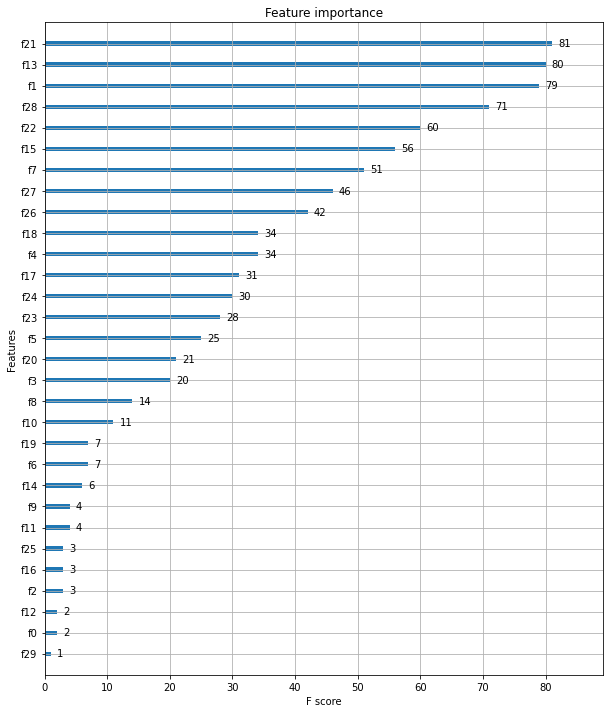

In [44]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig,ax = plt.subplots(figsize=(10,12))
plot_importance(xgb_model, ax=ax)

---

결정 트리에서 보여준 트리 기반 구조도 xgboost에서 시각화 가능(to_graphviz() API 이용)

사이킷런의 GridSearchCV와 유사하게 데이터 세트에 대한 교차 검증 수행 후 최적 파라미터를 구할 수 있는 방법을 cv() API로 제공.

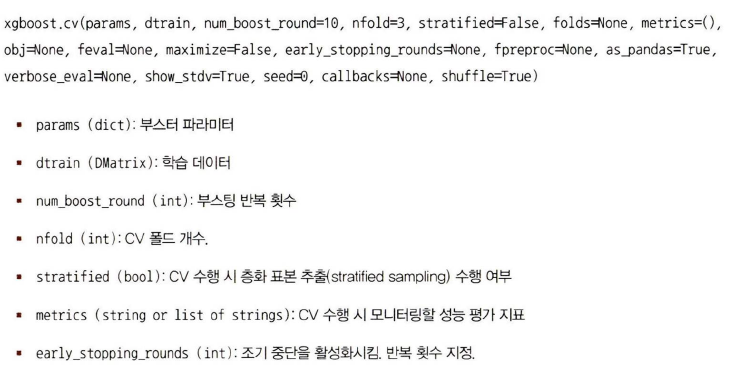

xgb.cv의 반환값은 DataFrame 형태.

---

###**사이킷런 래퍼 XGBoost의 개요 및 적용**

사이킷런의 프레임워크와 연동하기 위해 사이킷런 전용의 XGBoost 래퍼 클래스 개발됨.

* 사이킷런의 기본 Estimator를 그대로 상속해 만들었기 때문에 다른 Estimator와 동일하게 fit()과 predict()만으로 학습과 예측 가능

크게 분류를 하면,

**XGBClassifier**: 분류를 위한 래퍼 클래스

**XGBRegressor**: 회귀를 위한 래퍼 클래스

기존 xgboost 모듈에서 사용하던 네이티브 하이퍼 파라미터를 다음과 같이 변경

* eta -> learning_rate
* sub_sample -> subsample
* lambda -> reg_lambda
* alpha -> reg_alpha

---

위스콘신 대학병원의 유방암 데이터 세트를 분류를 위한 래퍼 클래스인 XGBClassifier를 이용해 예측해보기

In [45]:
#사이킷런 래퍼 XGBoost 클래스인 XGBClassifier 임포트
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb_wrapper.fit(X_train, y_train)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]

In [46]:
#사이킷런 래퍼 XGBoost로 만들어진 모델의 예측 성능 평가
get_clf_eval(y_test, w_preds, w_pred_proba)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870,F1: 0.9806, AUC:0.9951


->앞 예제의 파이썬 래퍼 XGBoost와 동일한 평가 결과가 나옴

---

사이킷런 래퍼 XGBoost에서도 조기 중단 수행 가능.

fit()에 **조기 중단** 관련된 파라미터를 입력하면 됨.

<u>관련 파라미터: </u>

early_stopping_rounds: 평가 지표가 향상될 수 있는 반복 횟수 정의

eval_metric: 조기 중단을 위한 평가 지표

eval_set: 성능 평가를 수행할 데이터 세트



In [47]:
#이 예제는 데이터 세트의 크기가 작아 테스트 데이터를 평가용 데이터로 사용함
#이럴 경우 학습 시 미리 참고가 되어 과적합할 수 있기 때문에 적절하지 않은 예제
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
evals=[(X_test, y_test)]
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss",
                eval_set=evals, verbose=True)
ws100_preds = xgb_wrapper.predict(X_test)
ws100_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]

[0]	validation_0-logloss:0.61352
Will train until validation_0-logloss hasn't improved in 100 rounds.
[1]	validation_0-logloss:0.547842
[2]	validation_0-logloss:0.494247
[3]	validation_0-logloss:0.447986
[4]	validation_0-logloss:0.409109
[5]	validation_0-logloss:0.374977
[6]	validation_0-logloss:0.345714
[7]	validation_0-logloss:0.320529
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.277991
[10]	validation_0-logloss:0.260302
[11]	validation_0-logloss:0.246037
[12]	validation_0-logloss:0.231556
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.208572
[15]	validation_0-logloss:0.199993
[16]	validation_0-logloss:0.190118
[17]	validation_0-logloss:0.181818
[18]	validation_0-logloss:0.174729
[19]	validation_0-logloss:0.167657
[20]	validation_0-logloss:0.158202
[21]	validation_0-logloss:0.154725
[22]	validation_0-logloss:0.148947
[23]	validation_0-logloss:0.143308
[24]	validation_0-logloss:0.136344
[25]	validation_0-logloss:0.132778
[26]	validation_0-logloss:0.127912

-> n_estimators를 400으로 설정해도 400번 반복을 수행하지 않고 311번 반복한 후 학습을 완료함.

**311번 반복한 후 멈춘 이유:**

211번 반복 시 logloss가 0.085593이고 311번 반복 시 logloss가 0.085948인데,

211번에서 311번까지 early_stopping_rounds=100으로 지정된 100번의 반복 동안 성능 평가 지수가 향상되지 않았기 때문에 더 이상 반복하지 않고 멈춘 것

In [48]:
#조기 중단으로 학습된 XGBClassifier의 예측 성능 살펴보기
#조기 중단이 적용되지 않은 결과보다 약간 저조한 성능을 나타냈지만 큰 차이는 아님
get_clf_eval(y_test, ws100_preds, ws100_pred_proba)

오차 행렬
[[34  3]
 [ 1 76]]
정확도: 0.9649, 정밀도: 0.9620, 재현율: 0.9870,F1: 0.9744, AUC:0.9954


조기 중단값을 너무 급격하게 줄이면 예측 성능 저하될 수 있음

In [49]:
#early_stopping_rounds를 10으로 설정하고 재학습
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=10,
                eval_metric="logloss",eval_set=evals, verbose=True)

ws10_preds = xgb_wrapper.predict(X_test)
ws10_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]
get_clf_eval(y_test, ws10_preds, ws10_pred_proba)

[0]	validation_0-logloss:0.61352
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.547842
[2]	validation_0-logloss:0.494247
[3]	validation_0-logloss:0.447986
[4]	validation_0-logloss:0.409109
[5]	validation_0-logloss:0.374977
[6]	validation_0-logloss:0.345714
[7]	validation_0-logloss:0.320529
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.277991
[10]	validation_0-logloss:0.260302
[11]	validation_0-logloss:0.246037
[12]	validation_0-logloss:0.231556
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.208572
[15]	validation_0-logloss:0.199993
[16]	validation_0-logloss:0.190118
[17]	validation_0-logloss:0.181818
[18]	validation_0-logloss:0.174729
[19]	validation_0-logloss:0.167657
[20]	validation_0-logloss:0.158202
[21]	validation_0-logloss:0.154725
[22]	validation_0-logloss:0.148947
[23]	validation_0-logloss:0.143308
[24]	validation_0-logloss:0.136344
[25]	validation_0-logloss:0.132778
[26]	validation_0-logloss:0.127912


early_stopping_rounds=100일 때의 결과 정확도보다 낮음

---

피처의 중요도를 시각화하는 모듈인 plot_importance() API에 사이킷런-래퍼 클래스를 입력해도 앞에서 한 것과 똑같이 시각화 결과 도출

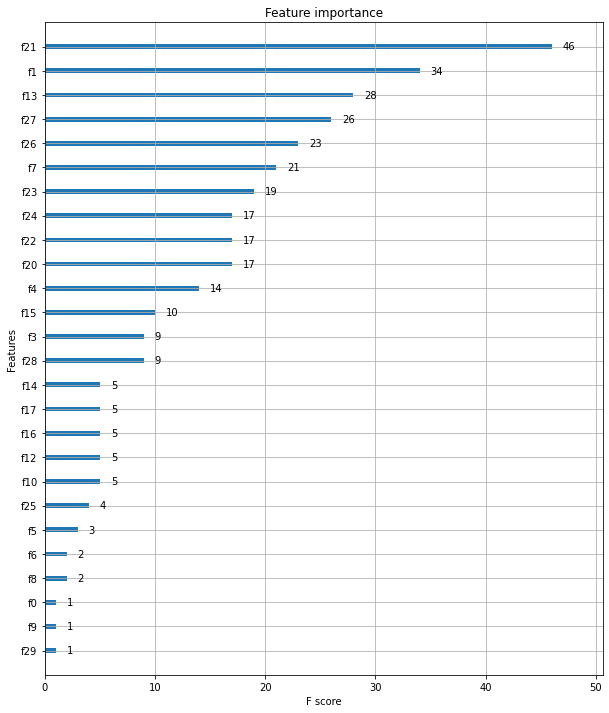

In [50]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
#사이킷런 Wrapper 클래스를 입력해도 무방
plot_importance(xgb_wrapper, ax=ax)

# **07 LightGBM**

---

* XGBoost와 함께 부스팅 계열 알고리즘에서 가장 각광을 받고 있음
* XGBoost는 매우 뛰어난 부스팅 알고리즘이지만, 여전히 학습 시간이 오래 걸림(GridSearchCV로 하이퍼 파라미터 튜닝을 수행하기 때문에 수행 시간이 오래 걸려 파라미터를 튜닝하기에 안좋음)
* LightGBM의 가장 큰 장점이 XGBoost보다 학습에 걸리는 시간이 훨씬 적다는 점. 메모리 사용량도 상대적으로 적음

한 가지 단점: 적은 데이터 세트에 적용할 경우 과적합이 발생하기 쉬움(일반적으로 10,000건 이하의 데이터 세트 정도)

---

LightGBM은 일반 GBM 계열의 트리 분할 방법과 다르게 리프 중심 트리 분할(Leaf Wise) 방식을 사용.

기존의 대부분 트리 기반 알고리즘은 트리의 깊이를 효과적으로 줄이기 위한 균형 트리 분할(Level Wise) 방식을 사용함.

즉, 최대한 균형 잡힌 트리를 유지하면서 분할하기 때문에 트리의 깊이가 최소화될 수 있음

이렇게 균형 잡힌 트리를 생성하는 이유는 오버피팅에 보다 더 강한 구조를 가질 수 있다고 알려져 있기 때문

반대로 균형을 맞추기 위한 시간이 필요하다는 상대적인 단점 존재

하지만 <u>LightGBM</u>의 리프 중심 트리 분할 방식은 트리의 균형을 맞추지 않고,

최대 손실 값(max delta loss)을 가지는 리프 노드를 지속적으로 분할하면서 트리의 깊이가 깊어지고 비대칭적인 규칙 트리가 생성됨.

하지만 이렇게 최대 손실값을 가지는 리프 노드를 지속적으로 분할해 생성된 규칙 트리는 학습을 반복할수록 결국은 균형 트리 분할 방식보다 예측 오류 손실을 최소화할 수 있다는 것이 LightGBM의 구현 사상.

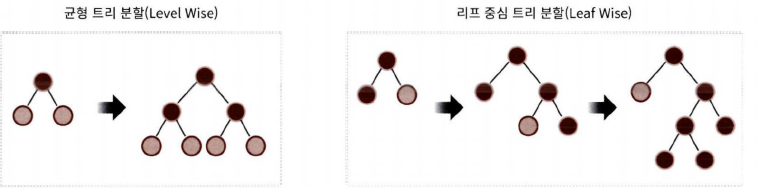

## **LightGBM 하이퍼 파라미터**

LightGBM 하이퍼 파라미터는 XGBoost와 많은 부분이 유사함.

주의해야 할 점은 LightGBM은 Xgboost와 다르게 리프 노드가 계속 분할되면서 트리의 깊이가 깊어지므로 이러한 트리 특성에 맞는 하이퍼 파라미터 설정이 필요함(예를 들어 max_depth를 매우 크게 가지기)

**주요 파라미터**

* num_iterations[default=100]: 반복 수행하려는 트리의 개수 지정. 크게 지정할수록 예측 성능이 높아질 수 있으나, 너무 크게 지정하면 오히려 과적합으로 성능이 저하될 수 있음(=n_estimators)
* learning_rate[default=0.1]: 0에서 1 사이의 값을 지정하며 부스팅 스텝을 반복적으로 수행할 때 업데이트되는 학습률 값. 일반적으로 n_estimators를 크게 하고 learning_rate를 작게 해서 예측 성능을 향상시킬 수 있으나, 마찬가지로 과적합 이슈와 학습 시간이 길어지는 부정적인 영향도 고려해야함.
* max_depth[default=-1]: 트리 기반 알고리즘의 max_Depth와 같음. 0보다 작은 값을 지정하면 깊이에 제한이 없음. 지금까지 소개한 Depth wise 방식의 트리와 다르게 LightGBM은 leaf wise 기반이므로 깊이가 상대적으로 더 깊음
* min_data_in_leaf[default=20]: 결정 트리의 min_samples_leaf와 같은 파라미터. 하지만 사이킷런 래퍼 LightGBM 클래스인 LightGBMClassifier에서는 min_child_samples 파라미터로 이름이 변경됨. 최종 결정 클래스인 리프 노드가 되기 위해서 최소한으로 필요한 레코드 수, 과적합을 제어하기 위한 파라미터
* num_leaves[default=31]: 하나의 트리가 가질 수 있는 최대 리프 개수
* boosting[default=gbdt]: 부스팅의 트리를 생성하는 알고리즘을 기술
* bagging_fraction[default=1.0]: 트리가 커져서 과적합되는 것을 제어하기 위해서 데이터를 샘플링하는 비율을 지정함.
* feature_fraction[default=1.0]: 개별 트리를 학습할 떄마다 무작위로 선택하는 피처의 비율. 과적합을 막기 위해 사용됨.
* labda_l2[default=0.0]: L2 regulation 제어를 위한 값. 피처 개수가 많을 경우 적용을 검토하며 값이 클수록 과적합 감소 효과 있음
* lambda_l1[default=0.0]: L1 regulation 제어를 위한 값. L2와 마찬가지로 과적합 제어를 위한 것이며, XGBClassifier의 reg_alpha와 동일하므로 LightGBMClassifier에서는 reg_alpha로 변경됨.

**Learning Task 파라미터**
* objective: 최솟값을 가져야 할 손실함수를 정의.

## **하이퍼 파라미터 튜닝 방안**

num_leaves의 개수를 중심으로 min_child_samples(min_data_in_leaf), max_depth를 함께 조정하면서 모델의 복잡도를 줄이는 것이 기본 튜닝 방안.

learning_rate을 작게 하면서 n_estimators를 크게 하는 것은 부스팅 계열 튜닝에서 가장 기본적인 튜닝 방안이므로 이를 적용해도 괜찮음

n_estimators를 너무 크게 하는 것은 과적합으로 오히려 성능이 저하될 수 있음.

## 파이썬 래퍼 LightGBM과 사이킷런 래퍼 XGBoost, LightGBM 하이퍼 파라미터 비교

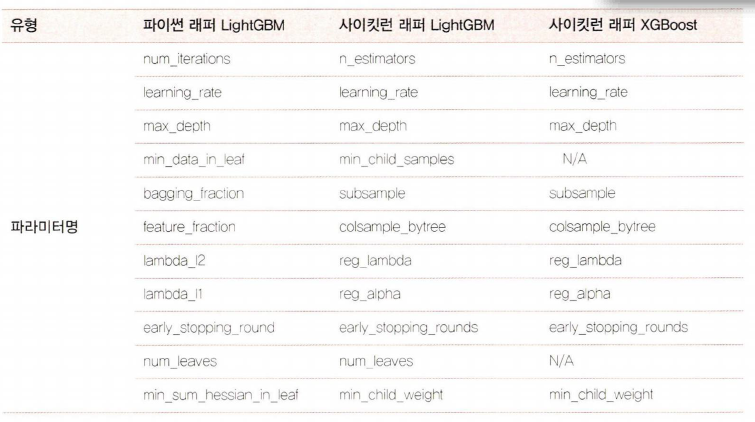

**LightGBM 적용 - 위스콘신 유방암 예측**

In [51]:
#LightGBM의 파이썬 패키지인 lightgbm에서 LGBMClassifier 임포트
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()
ftr = dataset.data
target = dataset.target

#전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(ftr, target, test_size=0.2, random_state=156)

#앞서 XGBoost와 동일하게 n_estimators는 400 설정
lgbm_wrapper = LGBMClassifier(n_estimators=400)

# LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능
evals = [(X_test, y_test)]
lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss",
                 eval_set=evals, verbose=True)
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:,1]

[1]	valid_0's binary_logloss: 0.565079	valid_0's binary_logloss: 0.565079
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.507451	valid_0's binary_logloss: 0.507451
[3]	valid_0's binary_logloss: 0.458489	valid_0's binary_logloss: 0.458489
[4]	valid_0's binary_logloss: 0.417481	valid_0's binary_logloss: 0.417481
[5]	valid_0's binary_logloss: 0.385507	valid_0's binary_logloss: 0.385507
[6]	valid_0's binary_logloss: 0.355846	valid_0's binary_logloss: 0.355846
[7]	valid_0's binary_logloss: 0.330897	valid_0's binary_logloss: 0.330897
[8]	valid_0's binary_logloss: 0.306923	valid_0's binary_logloss: 0.306923
[9]	valid_0's binary_logloss: 0.28776	valid_0's binary_logloss: 0.28776
[10]	valid_0's binary_logloss: 0.26917	valid_0's binary_logloss: 0.26917
[11]	valid_0's binary_logloss: 0.250954	valid_0's binary_logloss: 0.250954
[12]	valid_0's binary_logloss: 0.23847	valid_0's binary_logloss: 0.23847
[13]	valid_0's binary_logloss: 0.225865	valid_0's bi

조기 중단으로 147번 반복까지만 수행하고 학습을 종료함.

In [52]:
#학습된 LightGBM 모델을 기반으로 예측 성능을 평가하기
get_clf_eval(y_test, preds, pred_proba)

오차 행렬
[[33  4]
 [ 2 75]]
정확도: 0.9474, 정밀도: 0.9494, 재현율: 0.9740,F1: 0.9615, AUC:0.9926


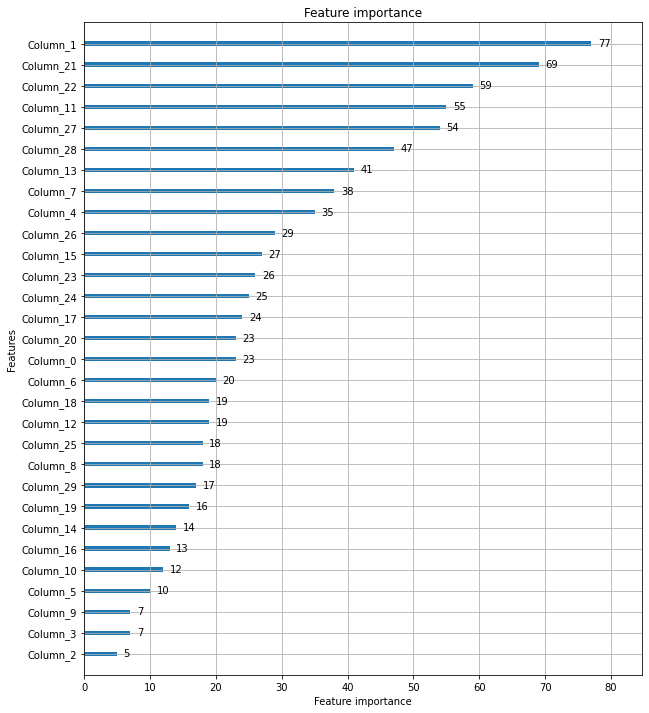

In [53]:
#plot_importance()를 이용해 피처 중요도 시각화
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(lgbm_wrapper, ax=ax)

# **10 스태킹 앙상블**

---

스태킹(Stacking)은 개별적인 여러 알고리즘을 서로 결합해 예측 결과를 도출한다는 점에서

앞에 소개한 배깅(Bagging) 및 부스팅(Boosting)과 공통점을 가지고 있음

가장 큰 차이점은 <u>개별 알고리즘으로 예측한 데이터를 기반으로 다시 예측을 수행한다는 것</u>

즉, 개별 알고리즘의 예측 결과 데이터 세트를 최종적인 메타 데이터 세트로 만들어 별도의 ML 알고리즘으로 최종 학습을 수행하고 테스트 데이터를 기반으로 다시 최종 예측을 수행하는 방식

이렇게 개별 모델의 예측된 데이터 세트를 다시 기반으로 하여 학습하고 예측하는 방식을 메타 모델이라고 함

스태킹 모델은 두 종류의 모델 필요

첫번째: 개별적인 기반 모델, 두번째: 이 개별 기반 모델의 예측 데이터를 학습 데이터로 만들어서 학습하는 최종 메타 모델

여러 개별 모델의 예측 데이터를 각각 스태킹 형태로 결합해 최종 메타 모델의 학습용 피처 데이터 세트와 테스트용 피처 데이터 세트를 만드는 것

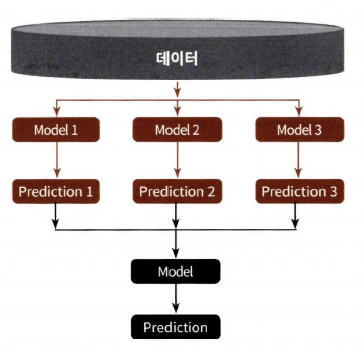

M개의 로우, N개의 피처(칼럼)을 가진 데이터 세트에 스태킹 앙상블을 적용한다고 가정. 학습에 사용할 ML 알고리즘 모델은 모두 3개.

먼저 모델별로 각각 학습을 시킨 뒤 예측을 수행하면 각각 M개의 로우를 가진 1개의 레이블 값 도출됨.

모델별로 도출된 예측 레이블 값을 다시 합해서(스태킹) 새로운 데이터 세트를 만들고 이렇게 스태킹된 데이터 세트에 대해 최종 모델을 적용해 최종 예측

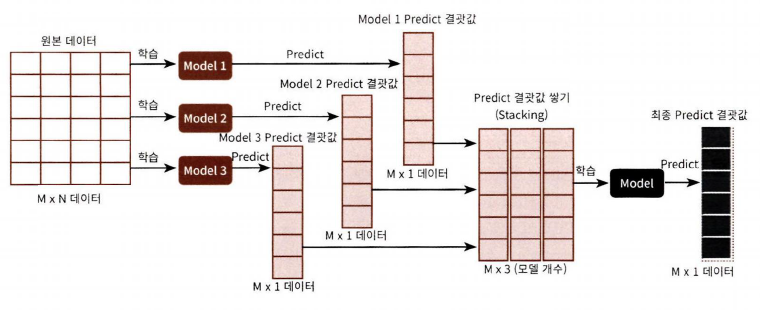

###**기본 스태킹 모델**

In [54]:
#기본 스태킹 모델을 위스콘신 암 데이터 세트에 적용해보기
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data = load_breast_cancer()

X_data = cancer_data.data
y_label = cancer_data.target

X_train, X_test, y_train, y_test = train_test_split(X_data,y_label, test_size=0.2, random_state=0)

In [55]:
#개별 ML 모델 생성(kNN,랜덤 포레스트, 결정트리, 에이다부스트)
knn_clf = KNeighborsClassifier(n_neighbors=4)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators=100)

#스태킹으로 만들어진 데이터 세트를 학습, 예측할 최종모델(로지스틱 회귀)
lr_final = LogisticRegression(C=10)

In [56]:
#개별 모델들을 학습
knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
dt_clf.fit(X_train, y_train)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100)

In [57]:
#학습된 개별 모델들이 각자 반환하는 예측 데이터 세트를 생성하고 개별 모델의 정확도 측정
knn_pred = knn_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)
dt_pred = dt_clf.predict(X_test)
ada_pred = ada_clf.predict(X_test)

print('KNN 정확도: {0:.4f}'.format(accuracy_score(y_test, knn_pred)))
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('결정 트리 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))
print('에이다부스트 정확도: {0:.4f}'.format(accuracy_score(y_test, ada_pred)))

KNN 정확도: 0.9211
랜덤 포레스트 정확도: 0.9649
결정 트리 정확도: 0.9123
에이다부스트 정확도: 0.9561


In [58]:
pred = np.array([knn_pred, rf_pred, dt_pred, ada_pred])
print(pred.shape)

#trainspose를 이용해 행과 열의 위치 교환. 칼럼 레벨로 각 알고리즘의 예측 결과를 피처로 만듦.
pred = np.transpose(pred)
print(pred.shape)

(4, 114)
(114, 4)


In [59]:
#최종 메타 모델인 로지스틱 회귀 학습, 예측 정확도 측정
lr_final.fit(pred, y_test)
final = lr_final.predict(pred)

print('최종 메타 모델의 예측 정확도: {0:.4f}.format(accuracy_score(y_test, final')

최종 메타 모델의 예측 정확도: {0:.4f}.format(accuracy_score(y_test, final


### **CV 세트 기반의 스태킹**

CV 세트 기반의 스태킹 모델은 과적합을 개선하기 위해 최종 메타 모델을 위한 데이터 세트를 만들 때 교차 검증 기반으로 예측된 결과 데이터 세트를 이용.

* 스텝 1: 각 모델별로 원본 학습/테스트 데이터를 예측한 결과값을 기반으로 메타 모델을 위한 학습용/테스트용 데이터 생성
* 스텝 1에서 개별 모델들이 생성한 학습용 데이터를 모두 스태킹 형태로 합쳐서 메타 모델이 학습할 최종 학습용 데이터 생성. 마찬가지로 각 모델들이 생성한 테스트용 데이터를 모두 스태킹 형태로 합쳐서 메타 모델이 예측할 최종 테스트 데이터 세트 생성. 메타 모델은 최종적으로 생성된 학습 데이터 세트와 원본 학습 데이터의 레이블의 레이블 데이터를 기반으로 학습한 뒤, 최종적으로 생성된 테스트 데이터 세트를 예측하고, 원본 테스트 데이터의 레이블 데이터를 기반으로 평가

**스텝1**

핵심: 개별 모델에서 메타 모델인 2차 모델에서 사용될 학습용 데이터와 학습용 데이터를 교차 검증을 통해 생성하는 것. 개별 모델 레벨에서 수행하며, 이러한 로직을 여러 개의 개별 모델에서 동일하게 수행

학습용 데이터를 N개의 폴드(Fold)로 나눔(3개의 폴드세트 가정).

3번의 유사한 반복 작업을 수행한 후 마지막 3번째 반복에서 개별 모델의 예측값으로 학습 데이터와 테스트 데이터 생성
1.   학습용 데이터를 3개의 폴드로 나누되, 2개의 폴드는 하급을 위한 데이터 폴드로, 나머지 1개의 폴드는 검증을 위한 데이터 폴드로 나눔. 이렇게 2개의 폴드로 나뉜 학습 데이터를 기반으로 개별 모델을 학습시킴
2.   이렇게 학습된 개별 모델은 검증 폴드 1개 데이터로 예측하고 그 결과를 저장. 이러한 로직을 3번 반복하며 학습 데이터와 검증 데이터 세트를 변경해가면서 학습 후 예측 결과를 별도로 저장. 이렇게 만들어진 예측 데이터는 메타 모델을 학습시키는 학습 데이터로 사용됨
3.  2개의 학습 폴드 데이터로 학습된 개별 모델은 원본 테스트 데이터를 예측하여 예측값을 생성. 마찬가지로 이러한 로직을 3번 반복하면서 이 예측값의 평균으로 최종 결괏값을 생성하고 이를 메타 모델을 위한 테스트 데이터로 사용.





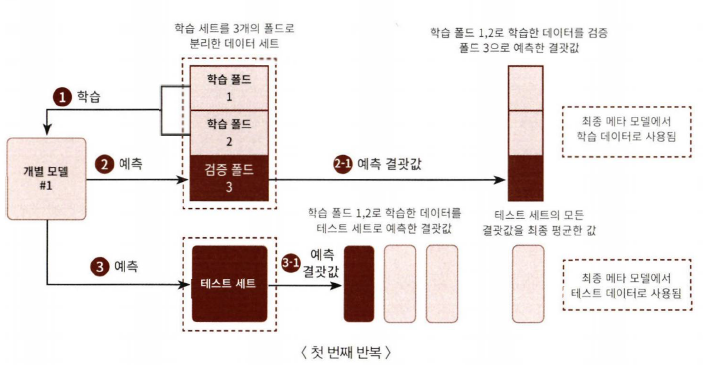

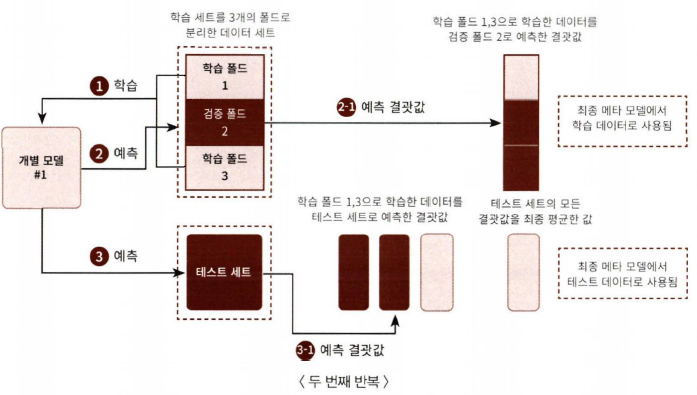

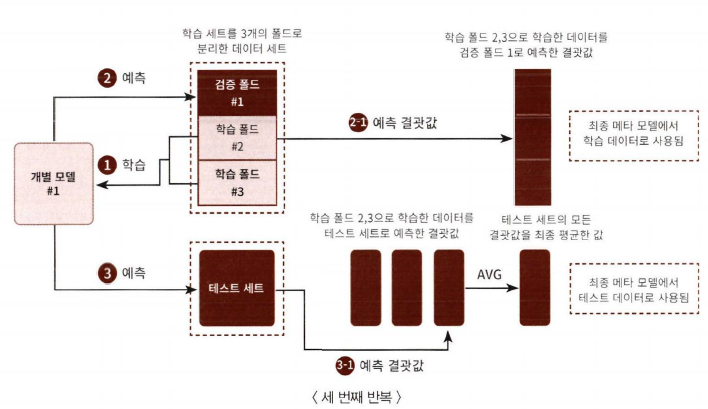

**스텝 2**

각 모델들이 스텝 1로 생성한 학습과 테스트 데이터를 모두 합쳐서 최종적으로 메타 모델이 사용할 학습 데이터와 테스트 데이터 생성.

메타 모델이 사용할 최종 학습 데이터와 원본 데이터의 레이블 데이터를 합쳐서 메타 모델을 학습한 후에 최종 테스트 데이터로 예측을 수행한 뒤, 최종 예측 결과를 원본 테스트 데이터의 레이블 데이터와 비교해 평가

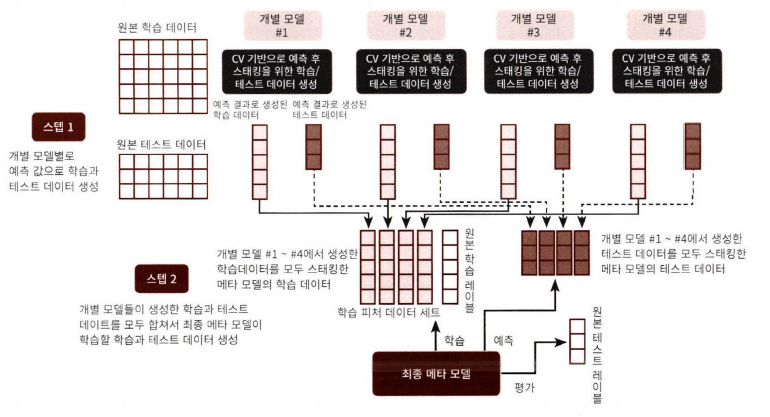

---

Step 1부터 코드로 구현.

In [69]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

#개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 윟나 함수
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
  #지정된 n_folds 값으로 KFold 생성
  kf = KFold(n_splits=n_folds, shuffle=True, random_state=0)
  #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
  train_fold_pred = np.zeros((X_train_n.shape[0],1))
  test_pred = np.zeros((X_test_n.shape[0], n_folds))
  print(model.__class__.__name__,'model 시작')

  for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
    #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 세트 추출
    print('\t 폴드 세트: ', folder_counter, '시작')
    X_tr = X_train_n[train_index]
    y_tr = y_train_n[train_index]
    X_te = X_train_n[valid_index]

    #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행
    model.fit(X_tr, y_tr)
    #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장
    train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
    #입력된 원본 테스트 데이터를 폴드 세트 내 학습된 기반 모델에서 예측 후 데이터 저장
    test_pred[:, folder_counter] = model.predict(X_test_n)

  #폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
  test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)

  #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
  return train_fold_pred, test_pred_mean

In [70]:
#이제 여러 개의 분류 모델 별로 stack_base_model() 함수 수행
#개별 모델은 앞의 스태킹 모델에서 생성한 KNN, 랜덤 포레스트, 결정 트리, 에이다부스트 모델
#이들 모델별로 get_stacking_base_datasets() ㅎ마수를 호출해 각각 메타 모델이 추후에 사용할 학습용, 테스트용 데이터 세트 반환
knn_train, knn_test = get_stacking_base_datasets(knn_clf, X_train, y_train, X_test, 7)
rf_train, rf_test = get_stacking_base_datasets(rf_clf, X_train, y_train, X_test, 7)
dt_train, dt_test = get_stacking_base_datasets(dt_clf, X_train, y_train, X_test, 7)
ada_train, ada_test = get_stacking_base_datasets(ada_clf, X_train, y_train, X_test, 7)

KNeighborsClassifier model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작
	 폴드 세트:  5 시작
	 폴드 세트:  6 시작
RandomForestClassifier model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작
	 폴드 세트:  5 시작
	 폴드 세트:  6 시작
DecisionTreeClassifier model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작
	 폴드 세트:  5 시작
	 폴드 세트:  6 시작
AdaBoostClassifier model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작
	 폴드 세트:  5 시작
	 폴드 세트:  6 시작


In [71]:
#Step2 구현
Stack_final_X_train = np.concatenate((knn_train, rf_train, dt_train, ada_train),axis=1)
Stack_final_X_test = np.concatenate((knn_test, rf_test, dt_test, ada_test),axis=1)
print('원본 학습 피처 데이터 Shape:', X_train.shape, '원본 테스트 피처 Shape:', X_test.shape)
print('스태킹 학습 피처 데이터 Shape:', Stack_final_X_train.shape,
      '스태킹 테스트 피처 데이터 Shape:', Stack_final_X_test.shape)

원본 학습 피처 데이터 Shape: (455, 30) 원본 테스트 피처 Shape: (114, 30)
스태킹 학습 피처 데이터 Shape: (455, 4) 스태킹 테스트 피처 데이터 Shape: (114, 4)


이렇게 만들어진 Stack_final_X_train은 메타 모델이 학습할 학습용 피처 데이터 세트.

Stack_final_X_test는 메타 모델이 예측할 테스트용 피처 데이터 세트

In [72]:
#최종 메타 모델인 로지스틱 회귀를 스태킹된 학습용 피처 데이터 세트와 원본 학습 레이블 데이터로 학습한 후
#스태킹된 테스트 데이터 세트로 예측하고, 예측 결과를 원본 테스트 레이블 데이터와 비교해 정확도 측정
lr_final.fit(Stack_final_X_train, y_train)
stack_final = lr_final.predict(Stack_final_X_test)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, stack_final)))

최종 메타 모델의 예측 정확도: 0.9737
